In [71]:
import logging
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import os

# external imports

from kwave.data import Vector  # type: ignore
from kwave.kgrid import kWaveGrid  # type: ignore
from kwave.kmedium import kWaveMedium  # type: ignore
from kwave.kspaceFirstOrder3D import kspaceFirstOrder3D  # type: ignore
from kwave.ktransducer import NotATransducer, kWaveTransducerSimple  # type: ignore
from kwave.options.simulation_execution_options import SimulationExecutionOptions  # type: ignore
from kwave.options.simulation_options import SimulationOptions  # type: ignore
from kwave.utils.dotdictionary import dotdict  # type: ignore
from kwave.utils.signals import tone_burst, get_win  # type: ignore
from kwave.utils.filters import gaussian_filter  # type: ignore
from kwave.utils.conversion import db2neper  # type: ignore
from kwave.reconstruction.tools import log_compression  # type: ignore
from kwave.reconstruction.beamform import envelope_detection  # type: ignore
from kwave.utils.mapgen import make_ball  # type: ignore

In [72]:
import json
import scipy.io

from utils_ex.sim_params import Params
from utils_ex.helper import (
    get_transducer,
    make_grid,
    get_input_signal,
    solve_kspace_problem,
    process_simulation_data,
)
from utils_ex.artifacts import get_phantom_data_circle

from kwave.kmedium import kWaveMedium  # type: ignore
from kwave.data import Vector  # type: ignore

In [73]:
import json
from utils_ex.sim_params import Params
from utils_ex.helper import *
from utils_ex.artifacts import (
    get_phantom_data_circle,
    visualize_maps,
    visualize_receiver_part,
    get_3d_circle
)

from kwave.kmedium import kWaveMedium  # type: ignore
from kwave.data import Vector  # type: ignore


%load_ext autoreload
%autoreload 2

class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, Vector):
            return obj.__dict__  # or any other way to serialize Vector
        return super().default(obj)


def save_json(data, filename="parameters"):
    # Assuming args is an object with attributes
    with open(f"{data.RESULTS_DIR}/{data.experiment_name}/{filename}.json", "w") as f:
        json.dump(data.__dict__, f, cls=CustomEncoder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Running Simulation
Definign the grid
Defining the input signal
Defining the transducer
Getting the phantom
Getting the phantom


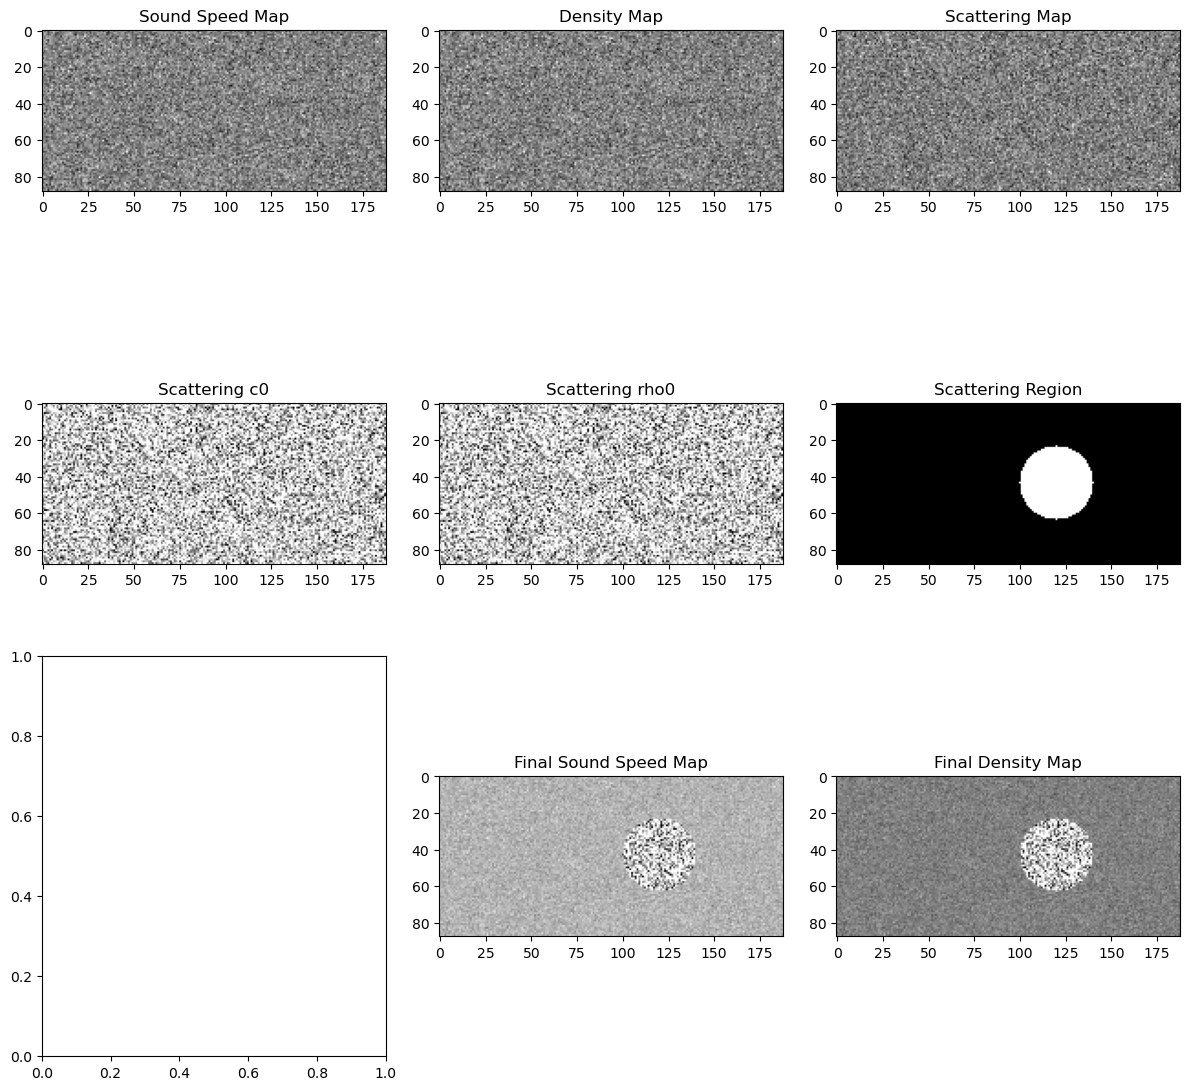

Running the simulation
Running the simulation
Computing scan line 0 of 48
Computing scan line 1 of 48
Computing scan line 2 of 48
Computing scan line 3 of 48
Computing scan line 4 of 48
Computing scan line 5 of 48
Computing scan line 6 of 48
Computing scan line 7 of 48
Computing scan line 8 of 48
Computing scan line 9 of 48
Computing scan line 10 of 48
Computing scan line 11 of 48
Computing scan line 12 of 48
Computing scan line 13 of 48
Computing scan line 14 of 48
Computing scan line 15 of 48
Computing scan line 16 of 48
Computing scan line 17 of 48
Computing scan line 18 of 48
Computing scan line 19 of 48
Computing scan line 20 of 48
Computing scan line 21 of 48
Computing scan line 22 of 48
Computing scan line 23 of 48
Computing scan line 24 of 48
Computing scan line 25 of 48
Computing scan line 26 of 48
Computing scan line 27 of 48
Computing scan line 28 of 48
Computing scan line 29 of 48
Computing scan line 30 of 48
Computing scan line 31 of 48
Computing scan line 32 of 48
Computi

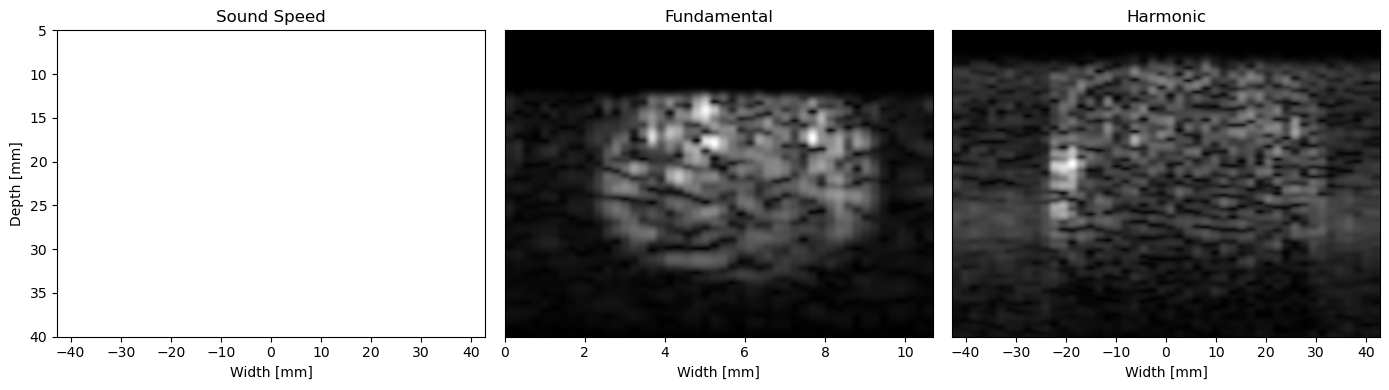

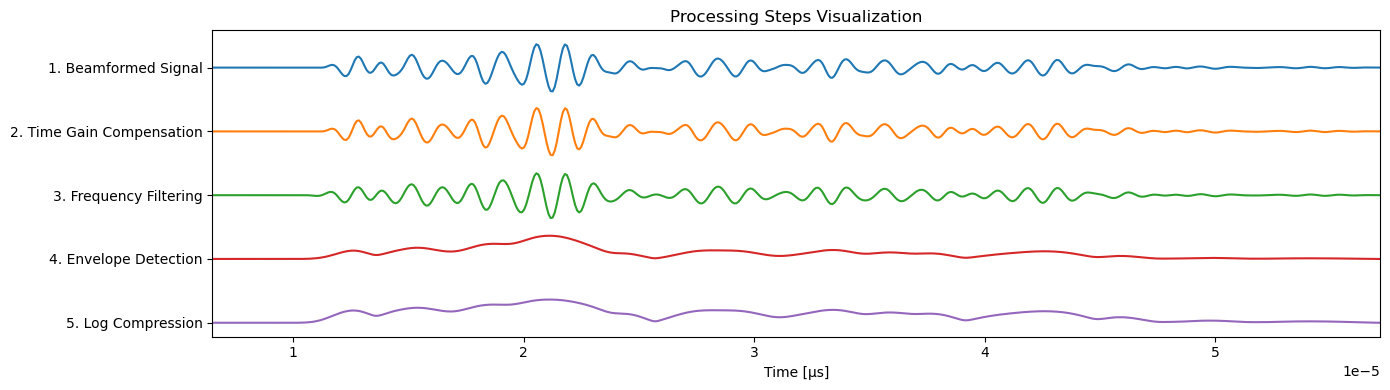

In [74]:
args = Params()
args.RUN_SIMULATION = False
# args.experiment_name = "triangle_check"
args.experiment_name = "exp_7_circle_normal_noise"
# os.makedirs(f"{args.RESULTS_DIR}/{args.experiment_name}", exist_ok=True)
print("Running Simulation")
# define the grid
grid_size_points = args.grid_size_points
grid_size_points.y = grid_size_points.y + args.number_scan_lines * args.transducer_element_width

grid_spacing_meters = args.grid_spacing_meters
c0 = args.c0
rho0 = args.rho0
tone_burst_freq = args.tone_burst_freq
tone_burst_cycles = args.tone_burst_cycles
SOME_TIME_CONSTANT = args.SOME_TIME_CONSTANT
source_strength = args.source_strength


# create the computational grid
print("Definign the grid")
t_end = (grid_size_points.x * grid_spacing_meters.x) * SOME_TIME_CONSTANT / c0  # [s]
kgrid = make_grid(grid_size_points, grid_spacing_meters, c0, t_end=t_end)
# create the time array and input signal
print("Defining the input signal")
input_signal = get_input_signal(
    kgrid, tone_burst_freq, tone_burst_cycles, source_strength, c0, rho0
)
# define the transducer properties
print("Defining the transducer")
not_transducer, transducer = get_transducer(grid_size_points, input_signal, kgrid, c0,sc = args.sc)
# define the medium properties
medium = kWaveMedium(
    sound_speed=None,  # will be set later
    alpha_coeff=args.alpha_coeff,
    alpha_power=args.alpha_power,
    BonA=args.BonA,
)
# get the phantom
print("Getting the phantom")
# get the phantom
print("Getting the phantom")
phantom = get_phantom_data_circle(
    kgrid=kgrid,
    params=args.__dict__,
    debug=True,
    element_width=transducer.element_width,
)
# get the phantom data and set the medium properties
medium.sound_speed = phantom["sound_speed_map"]
medium.density = phantom["density_map"]
# run the simulation to get scan lines
print("Running the simulation")
# run the simulation to get scan lines
print("Running the simulation")
scan_lines = solve_kspace_problem(
    kgrid=kgrid,
    medium=medium,
    args=args,
    sound_speed_map=phantom["sound_speed_map"],
    density_map=phantom["density_map"],
    grid_size_points=grid_size_points,
    transducer=transducer,
    not_transducer=not_transducer,        
)
# Process the scan lines using RF Signal Processing
print("Processing the scan lines")
processed_central_scan_line = process_simulation_data(kgrid=kgrid,
                        medium=medium,
                        input_signal=input_signal,
                        scan_lines=scan_lines,
                        tone_burst_freq=tone_burst_freq,
                        c0=c0,
                        args=args.__dict__,
                        t_end=t_end)

In [75]:
#  Vector([int(256/self.sc), int(128/self.sc), int(128/self.sc)]) - 2 * self.pml_size_points
Vector([int(256/args.sc), int(128/args.sc), int(128/args.sc)]) - 2 * args.pml_size_points

Vector([88, 44, 44])

(40.0, 5.0)

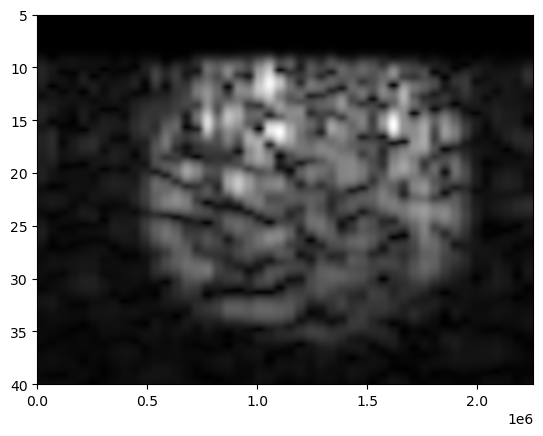

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming these variables are defined:
# scan_lines_fund -> The data to plot
# transducer_element_width -> Transducer element width (equivalent to transducer.element_width)
# dy -> Grid spacing in the y-direction (similar to 'dy' in MATLAB)
# scale_factor -> The scale factor applied in the code
# r -> The depth axis (similar to 'r' in MATLAB)
scan_lines_fund = processed_central_scan_line[0]
transducer_element_width = transducer.element_width
dy = grid_spacing_meters.y + args.number_scan_lines * args.transducer_element_width
scale_factor = 2
r = processed_central_scan_line[-1]
# Calculate the horizontal axis
horz_axis = np.arange(scan_lines_fund.shape[0]) * transducer_element_width * dy / scale_factor * 1e3  # in mm

# Plot the B-mode image
plt.figure()
plt.imshow(scan_lines_fund.T, cmap='gray', aspect='auto', extent=[horz_axis[0], horz_axis[-1], r[-1] * 1e3, r[0] * 1e3])

# Set axes properties
plt.gca().set_ylim(40, 5)


In [5]:
# # radius = 12e-3
# # x_pos = 2e-3
# # y_pos = 2e-3
# # z_pos = kgrid.dx * kgrid.Nz / 2
# # grid_size_points = Vector([kgrid.Nx, kgrid.Ny + number_scan_lines * element_width, kgrid.Nz])
# # # ball_center = np.round(Vector([50,50,50]))
# # scattering_region = make_ball(
# #     grid_size_points, ball_center, round(radius / kgrid.dx)
# # ).nonzero()
# # # Update the sound speed and density map
# # # all the locations where the scattering region is not zero, the speed sound map & density map will be updated with highly scattering region sound speed
# # # otherwise, all other locations are updated with the background sound speed
# # sound_speed_map[scattering_region] = scattering_c0[scattering_region]
# # density_map[scattering_region] = scattering_rho0[scattering_region]

# if debug:
#     visualize_maps(
#         sound_speed_map=init_sound_speed_map,
#         density_map=init_density_map,
#         scattering_map=scattering_map,
#         scattering_c0=scattering_c0,
#         scattering_rho0=scattering_rho0,
#         scattering_region=scattering_region,
#         final_sound_speed_map=sound_speed_map,
#         final_density_map=density_map,
#         save_path=f"{params['RESULTS_DIR']}/{params['experiment_name']}/phantom_maps.png",
#         show_fig=params["show_fig"],
#         params=params,
#     )

# Lets find the Parameters that control the level of noise

In [69]:
# find atleast 3 pairs of parameters that can be used to generate the same image with different speckle,reflections, and noise
# other noise
# once done with it, then define atleast 5 other masks that can be used to generate the same image with different speckle,reflections, and noise
# so there must be 15 different masks that can be used to generate the same image with different speckle,reflections, and noise

In [70]:
def get_3d_triangle(
    kgrid, grid_size_points, height=10, base=5, x_pos=32e-3, y_nod=2, z_nod=2
):
    """
    This method returns a 3D triangle object.
    Args:
        kgrid (dict): grid object
        grid_size_points (dict): size of grid points
        height (int): height of the triangle
        base (int): base width of the triangle
    """
    y_pos = kgrid.dy * kgrid.Ny / y_nod
    z_pos = kgrid.dz * kgrid.Nz / z_nod
    x_center = 25e-3

    # Define a simple triangle using grid points
    triangle_region = np.zeros(grid_size_points)
    for i in range(height):
        base_width = int(
            base * (1 - i / height)
        )  # decreasing base width as height increases
        triangle_region[
            int(x_center + i),
            int(y_pos - base_width // 2) : int(y_pos + base_width // 2),
            int(z_pos),
        ] = 1

    return triangle_region.nonzero()

In [71]:
def get_phantom_data_triangle(
    kgrid,
    params,
    debug=True,
    tranducer_width=2,
):
    """This method returns a phantom with a circle object.
    Args:
        kgrid (dict): _description_
        params (dict): _description_
        debug (bool): _description_
    Returns:
        dict: returns a phantom with a circle object wrapped in a dictionary
        with the following keys: sound_speed_map, density_map
    """
    # Load the parameters
    background_map_mean = params["background_map_mean"]
    background_map_std = params["background_map_std"]
    object_map_mean = params["object_map_mean"]
    object_map_std = params["object_map_std"]
    object_map_radius = params["object_map_radius"]
    object_map_center_x = params["object_map_center_x"]
    object_map_center_y = params["object_map_center_y"]
    object_map_center_z = params["object_map_center_z"]
    density_constant_multiplier = params["density_constant_multiplier"]
    lower_amplitude = params["lower_amplitude"]
    upper_amplitude = params["upper_amplitude"]
    c0 = params["c0"]
    rho0 = params["rho0"]
    grid_size_points = params["grid_size_points"]
    number_scan_lines = params["number_scan_lines"]
    # Grid spacing according to the example
    Nx_tot = kgrid.Nx
    Ny_tot = kgrid.Ny + number_scan_lines * tranducer_width
    Nz_tot = kgrid.Nz
    # Define the properties of the propagation medium
    background_map = background_map_mean + background_map_std * np.random.randn(
        Nx_tot, Ny_tot, Nz_tot
    )

    sound_speed_map = c0 * background_map
    density_map = rho0 * background_map
    if debug:
        init_sound_speed_map = sound_speed_map.copy()
        init_density_map = density_map.copy()
    # Define a random distribution of scatterers for the highly scattering region
    scattering_map = np.random.randn(Nx_tot, Ny_tot, Nz_tot)
    scattering_c0 = np.clip(
        c0 + object_map_mean + object_map_std * scattering_map,
        lower_amplitude,
        upper_amplitude,
    )
    scattering_rho0 = scattering_c0 / density_constant_multiplier
    # Define a sphere for a highly scattering region
    grid_size_points = Vector(
        [kgrid.Nx, kgrid.Ny + number_scan_lines * tranducer_width, kgrid.Nz]
    )
    scattering_region = get_3d_triangle(
        kgrid=kgrid,
        grid_size_points=grid_size_points,
    )
    # Update the sound speed and density map
    # all the locations where the scattering region is not zero, the speed sound map & density map will be updated with highly scattering region sound speed
    # otherwise, all other locations are updated with the background sound speed
    sound_speed_map[scattering_region] = scattering_c0[scattering_region]
    density_map[scattering_region] = scattering_rho0[scattering_region]
    if debug:
        visualize_maps(
            sound_speed_map=init_sound_speed_map,
            density_map=init_density_map,
            scattering_map=scattering_map,
            scattering_c0=scattering_c0,
            scattering_rho0=scattering_rho0,
            scattering_region=scattering_region,
            final_sound_speed_map=sound_speed_map,
            final_density_map=density_map,
            save_path=rf"{params['RESULTS_DIR']}/{params['experiment_name']}/phantom_maps.png",
            show_fig=params["show_fig"],
            params=params,
        )
    # Return
    phantom = {"sound_speed_map": sound_speed_map, "density_map": density_map}
    return phantom

# Analyze the results

In [72]:
import json
import scipy.io

from utils_ex.sim_params import Params
from utils_ex.helper import (
    get_transducer,
    make_grid,
    get_input_signal,
    solve_kspace_problem,
    process_simulation_data,
)
from utils_ex.artifacts import get_phantom_data_circle

from kwave.kmedium import kWaveMedium  # type: ignore
from kwave.data import Vector  # type: ignore


class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, Vector):
            return obj.__dict__  # or any other way to serialize Vector
        return super().default(obj)


def save_json(data, filename="parameters"):
    # Assuming args is an object with attributes
    with open(f"{data.RESULTS_DIR}/{data.experiment_name}/{filename}.json", "w") as f:
        json.dump(data.__dict__, f, cls=CustomEncoder)

In [ ]:
args = Params()  # loading the parameters
args.RUN_SIMULATION = False
args.COMPRESSION_RATIO = 30
args.show_fig = True
print("Running Simulation")
# define the grid
grid_size_points = args.grid_size_points
grid_spacing_meters = args.grid_spacing_meters
c0 = args.c0
rho0 = args.rho0
tone_burst_freq = args.tone_burst_freq
tone_burst_cycles = args.tone_burst_cycles
SOME_TIME_CONSTANT = args.SOME_TIME_CONSTANT
source_strength = args.source_strength

In [74]:
# args.object_map_center_x = 32e-3
# args.object_map_center_y = 2
# args.object_map_center_z = 2

In [75]:
# x_pos = 32e-3
# y_pos = 50 + (kgrid.dy * (kgrid.Ny) / 2)
# z_pos = kgrid.dz * kgrid.Nz / 2
# type(np.round(Vector([x_pos, y_pos, z_pos]) / kgrid.dx))

In [ ]:
medium.sound_speed.shape

In [ ]:
# create the computational grid
print("Definign the grid")
t_end = (grid_size_points.x * grid_spacing_meters.x) * SOME_TIME_CONSTANT / c0  # [s]
kgrid = make_grid(grid_size_points, grid_spacing_meters, c0, t_end=t_end)
# create the time array and input signal
print("Defining the input signal")
input_signal = get_input_signal(
    kgrid, tone_burst_freq, tone_burst_cycles, source_strength, c0, rho0
)
# define the transducer properties
print("Defining the transducer")
not_transducer, transducer = get_transducer(grid_size_points, input_signal, kgrid, c0)
# define the medium properties
medium = kWaveMedium(
    sound_speed=None,  # will be set later
    alpha_coeff=args.alpha_coeff,
    alpha_power=args.alpha_power,
    BonA=args.BonA,
)
# get the phantom
print("Getting the phantom")
phantom = get_phantom_data_circle(
    kgrid=kgrid,
    params=args.__dict__,
    debug=True,
    tranducer_width=transducer.element_width,
)
# get the phantom data and set the medium properties
medium.sound_speed = phantom["sound_speed_map"]
medium.density = phantom["density_map"]
# run the simulation to get scan lines
print("Running the simulation")
scan_lines = solve_kspace_problem(
    kgrid=kgrid,
    medium=medium,
    args=args,
    sound_speed_map=phantom["sound_speed_map"],
    density_map=phantom["density_map"],
    grid_size_points=grid_size_points,
    transducer=transducer,
    not_transducer=not_transducer,
)
# Process the scan lines using RF Signal Processing
print("Processing the scan lines")
processed_central_scan_line = process_simulation_data(
    kgrid=kgrid,
    medium=medium,
    input_signal=input_signal,
    scan_lines=scan_lines,
    tone_burst_freq=tone_burst_freq,
    c0=c0,
    args=args.__dict__,
    t_end=t_end,
)
# Save the parameters
print("Saving the parameters")
save_json(args)

In [ ]:
medium.density.shape

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.ndimage import zoom

# # Example data array (replace with your actual data)
# # processed_central_scan_line = np.random.rand(100, 100)
# data = processed_central_scan_line[0]

# # Normalize the data to avoid intensity artifacts
# data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

# # Interpolate the data
# zoom_factor = 200  # Adjust the zoom factor as needed
# data_interpolated = zoom(data, zoom_factor)

# # Plot the image
# plt.figure(figsize=(10, 6))
# plt.imshow(data_interpolated.T, aspect="auto", cmap="gray")
# plt.colorbar(label='Intensity')
# plt.title("Processed Central Scan Line (Interpolated)")
# plt.xlabel("Horizontal Position")
# plt.ylabel("Depth")
# plt.show()